In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch


from semeval.experiments.kosenko.language_bind.LanguageBind.languagebind import (
    LanguageBind,
    to_device,
    transform_dict,
    LanguageBindImageTokenizer,
)

In [2]:
device = "cuda:0"
device = torch.device(device)
clip_type = {
    "video": "LanguageBind_Video_FT",  # also LanguageBind_Video
    "audio": "LanguageBind_Audio_FT",  # also LanguageBind_Audio
    "thermal": "LanguageBind_Thermal",
    "image": "LanguageBind_Image",
    "depth": "LanguageBind_Depth",
}

model = LanguageBind(clip_type=clip_type, cache_dir="/code/cache_dir")
model = model.to(device)
model.eval()
pretrained_ckpt = f"LanguageBind/LanguageBind_Image"
tokenizer = LanguageBindImageTokenizer.from_pretrained(
    pretrained_ckpt, cache_dir="/code/cache_dir/tokenizer_cache_dir"
)
modality_transform = {
    c: transform_dict[c](model.modality_config[c]) for c in clip_type.keys()
}

In [26]:
video = [
    "semeval/experiments/kosenko/LanguageBind/assets/video/0.mp4",
]
language = [
    "A lion climbing a tree to catch a monkey.",
    "Training a parrot to climb up a ladder.",
    "Cute parrot is sitting on the floor.",
    "Parrot climbs the small stairs.",
    "Two pandas are eating bamboo.",
]

inputs = {
    "video": to_device(modality_transform["video"](video), device),
}
inputs["language"] = to_device(
    tokenizer(
        language,
        max_length=77,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    ),
    device,
)

with torch.no_grad():
    embeddings = model(inputs)

probs = torch.softmax(embeddings["video"] @ embeddings["language"].T, dim=-1)
sorted_indices = probs.topk(k=len(language)).indices.squeeze().tolist()
predicted_texts = "\n--\n".join([language[pos] for pos in sorted_indices])

print("Video x Text: \n", probs)
print(f"Most similar text is: \n{predicted_texts}")

Video x Text: 
 tensor([[9.2179e-08, 6.5961e-01, 6.4906e-04, 3.3974e-01, 5.2970e-09]],
       device='cuda:0')
Most similar text is: 
Training a parrot to climb up a ladder.
--
Parrot climbs the small stairs.
--
Cute parrot is sitting on the floor.
--
A lion climbing a tree to catch a monkey.
--
Two pandas are eating bamboo.


### Semeval Dataset

In [7]:
import json

dataset = json.loads(
    open("./SemEval-2024_Task3/training_data/Subtask_2_train.json").read()
)
conversation = dataset[0]
conversation

{'conversation_ID': 1,
 'conversation': [{'utterance_ID': 1,
   'text': 'Alright , so I am back in high school , I am standing in the middle of the cafeteria , and I realize I am totally naked .',
   'speaker': 'Chandler',
   'emotion': 'neutral',
   'video_name': 'dia1utt1.mp4'},
  {'utterance_ID': 2,
   'text': 'Oh , yeah . Had that dream .',
   'speaker': 'All',
   'emotion': 'neutral',
   'video_name': 'dia1utt2.mp4'},
  {'utterance_ID': 3,
   'text': 'Then I look down , and I realize there is a phone ... there .',
   'speaker': 'Chandler',
   'emotion': 'surprise',
   'video_name': 'dia1utt3.mp4'},
  {'utterance_ID': 4,
   'text': 'Instead of ... ?',
   'speaker': 'Joey',
   'emotion': 'surprise',
   'video_name': 'dia1utt4.mp4'},
  {'utterance_ID': 5,
   'text': 'That is right .',
   'speaker': 'Chandler',
   'emotion': 'anger',
   'video_name': 'dia1utt5.mp4'},
  {'utterance_ID': 6,
   'text': 'Never had that dream .',
   'speaker': 'Joey',
   'emotion': 'neutral',
   'video_nam

In [8]:
# emotions = list(set([item["emotion"] for item in conversation["conversation"]]))
emotions = list(set([f'{item["emotion"]}' for item in conversation["conversation"]]))


for dialogue_turn in conversation["conversation"]:
    video_path = dialogue_turn["video_name"]
    video = [
        f"SemEval-2024_Task3/training_data/train/{video_path}",
    ]

    inputs = {
        "video": to_device(modality_transform["video"](video), device),
    }
    inputs["language"] = to_device(
        tokenizer(
            emotions,
            max_length=77,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        ),
        device,
    )

    with torch.no_grad():
        embeddings = model(inputs)

    probs = torch.softmax(embeddings["video"] @ embeddings["language"].T, dim=-1)
    sorted_indices = probs.topk(k=len(emotions)).indices.squeeze().tolist()[0]
    print(f"Predicted emotion: {emotions[sorted_indices]} ")
    print(f"True Emotion: {dialogue_turn['emotion']}")
    print("---")
    # break

Predicted emotion: neutral 
True Emotion: neutral
---
Predicted emotion: anger 
True Emotion: neutral
---
Predicted emotion: anger 
True Emotion: surprise
---
Predicted emotion: anger 
True Emotion: surprise
---
Predicted emotion: anger 
True Emotion: anger
---
Predicted emotion: anger 
True Emotion: neutral
---
Predicted emotion: anger 
True Emotion: neutral
---
Predicted emotion: surprise 
True Emotion: neutral
---


In [37]:
video

['SemEval-2024_Task3/training_data/train/dia2utt3.mp4']

### Extract audio from video

In [2]:
import os
import tqdm

video_names = os.listdir("SemEval-2024_Task3/training_data/train")
for video_name in tqdm.tqdm(video_names):
    base_folder = "SemEval-2024_Task3/training_data/train/"
    video_path = f"{base_folder}{video_name}"
    audio_path = video_path.replace(".mp4", ".wav")
    os.system(
        f"ffmpeg -loglevel quiet -i {video_path} -vn -acodec pcm_s16le -ar 44100 -ac 2 {audio_path} -y"
    )
    # break

  0%|          | 4/18756 [00:00<08:04, 38.72it/s]

100%|██████████| 18756/18756 [10:35<00:00, 29.50it/s] 


### Use Audio

In [16]:
conversation = dataset[2]
# emotions = list(set([item["emotion"] for item in conversation["conversation"]]))
emotions = list(
    set([f'{item["emotion"]} emotion replica' for item in conversation["conversation"]])
)

correct_answers = 0
for dialogue_turn in conversation["conversation"]:
    video_path = dialogue_turn["video_name"]
    audio_path = video_path.replace(".mp4", ".wav")
    audio = [
        f"SemEval-2024_Task3/training_data/train/{audio_path}",
    ]

    inputs = {
        # "video": to_device(modality_transform["video"](video), device),
        "audio": to_device(modality_transform["audio"](audio), device),
    }
    dialogue_emotions = [f'{emotion}: {dialogue_turn["text"]}' for emotion in emotions]
    inputs["language"] = to_device(
        tokenizer(
            dialogue_emotions,
            max_length=77,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        ),
        device,
    )

    with torch.no_grad():
        embeddings = model(inputs)

    probs = torch.softmax(embeddings["audio"] @ embeddings["language"].T, dim=-1)
    sorted_indices = probs.topk(k=len(emotions)).indices.squeeze().tolist()[0]
    predicted_emotion = dialogue_emotions[sorted_indices]
    true_emotion = dialogue_turn["emotion"]
    if true_emotion in predicted_emotion:
        correct_answers += 1
    print(f"Predicted emotion: {predicted_emotion} ")
    print(f"True Emotion: {true_emotion}")
    print("---")
    # break
print(f"Accuracy: {correct_answers/len(conversation['conversation'])}")

Predicted emotion: neutral emotion replica: Oh my God ! 
True Emotion: surprise
---
Predicted emotion: neutral emotion replica: I know , I know , I am such an idiot . 
True Emotion: neutral
---
Predicted emotion: neutral emotion replica: I guess I should have caught on when she started going to the dentist four and five times a week . I mean , how clean can teeth get ? 
True Emotion: sadness
---
Predicted emotion: neutral emotion replica: My brother going through that right now , he is such a mess . How did you get through it ? 
True Emotion: neutral
---
Predicted emotion: neutral emotion replica: Well , you might try accidentally breaking something valuable of hers , say her ... 
True Emotion: neutral
---
Predicted emotion: neutral emotion replica: leg ? 
True Emotion: surprise
---
Predicted emotion: surprise emotion replica: That is one way ! 
True Emotion: joy
---
Predicted emotion: neutral emotion replica: Me , I ... I went for the watch . 
True Emotion: neutral
---
Predicted emoti

### Compute on all dataset

In [31]:
import tqdm

total_accurary = []
emotions = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]

for conversation in tqdm.tqdm(dataset):
    # conversation = dataset[2]
    # emotions = list(set([item["emotion"] for item in conversation["conversation"]]))

    correct_answers = 0
    for dialogue_turn in conversation["conversation"]:
        video_path = dialogue_turn["video_name"]
        audio_path = video_path.replace(".mp4", ".wav")
        audio = [
            f"SemEval-2024_Task3/training_data/train/{audio_path}",
        ]

        inputs = {
            # "video": to_device(modality_transform["video"](video), device),
            "audio": to_device(modality_transform["audio"](audio), device),
        }
        # dialogue_emotions = [
        #     f'{emotion}: {dialogue_turn["text"]}' for emotion in emotions
        # ]
        dialogue_emotions = emotions
        inputs["language"] = to_device(
            tokenizer(
                dialogue_emotions,
                max_length=77,
                padding="max_length",
                truncation=True,
                return_tensors="pt",
            ),
            device,
        )

        with torch.no_grad():
            embeddings = model(inputs)

        probs = torch.softmax(embeddings["audio"] @ embeddings["language"].T, dim=-1)
        # sorted_indices = probs.topk(k=len(emotions)).indices.squeeze().tolist()[0]
        sorted_indices = int(probs.argmax())
        predicted_emotion = dialogue_emotions[sorted_indices]
        true_emotion = dialogue_turn["emotion"]
        if true_emotion in predicted_emotion:
            correct_answers += 1
        # print(f"Predicted emotion: {predicted_emotion} ")
        # print(f"True Emotion: {true_emotion}")
        # print("---")
        # break
    local_accuracy = correct_answers / len(conversation["conversation"])
    total_accurary.append(local_accuracy)
    # print(f"Accuracy: {local_accuracy}")
    # break

print(f"Total accuracy: {torch.mean(torch.tensor(total_accurary))}")

100%|██████████| 1374/1374 [13:15<00:00,  1.73it/s]

Total accuracy: 0.08774463087320328


### Visualize embeddings

In [ ]:
import numpy as np
from sklearn.manifold import TSNE

X = np.array(
    [
        [0, 0, 0],
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 1],
        [1, 1, 2],
        [1, 5, 1],
    ]
)
X_embedded = TSNE(
    n_components=2,
    learning_rate="auto",
    init="random",
    perplexity=3,
).fit_transform(X)
X_embedded.shape, X_embedded

((6, 2),
 array([[-44.73028  ,  18.223143 ],
        [ -7.2480707,  -5.930153 ],
        [  3.0032792, -72.99377  ],
        [  1.4007347, -38.94259  ],
        [-35.137062 , -50.244877 ],
        [ 51.897522 , -14.130348 ]], dtype=float32))

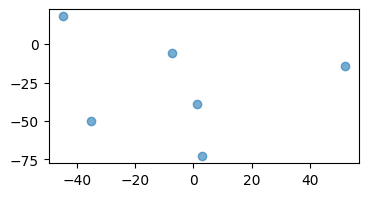

In [ ]:
import matplotlib.pyplot as plt

# FS = (10, 8)
FS = (4, 2)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
plt.scatter(
    X_embedded[:, :1],
    X_embedded[:, 1:],
    alpha=0.6,
)

#### Audio, Video

In [113]:
import tqdm

audio_embeddings = []
video_embeddings = []
emotion_labels = []

total_accurary = []
emotions = ["anger", "disgust", "fear", "joy", "sadness", "surprise"]
amount_conversations = 100

for i, conversation in tqdm.tqdm(enumerate(dataset)):
    # conversation = dataset[2]
    # emotions = list(set([item["emotion"] for item in conversation["conversation"]]))
    # if amount_conversations < i:
    #     break

    for dialogue_turn in conversation["conversation"]:
        video_path = dialogue_turn["video_name"]
        audio_path = video_path.replace(".mp4", ".wav")
        audio = [
            f"SemEval-2024_Task3/training_data/train/{audio_path}",
        ]
        video = [
            f"SemEval-2024_Task3/training_data/train/{video_path}",
        ]

        inputs = {
            "video": to_device(modality_transform["video"](video), device),
            "audio": to_device(modality_transform["audio"](audio), device),
        }

        with torch.no_grad():
            embeddings = model(inputs)

        true_emotion = dialogue_turn["emotion"]

        emotion_labels.append(true_emotion)
        audio_embeddings.append(embeddings["audio"].squeeze().cpu())
        video_embeddings.append(embeddings["video"].squeeze().cpu())

    total_accurary.append(local_accuracy)
    # print(f"Accuracy: {local_accuracy}")
    # break

1374it [1:02:56,  2.75s/it]


In [116]:
# X = torch.vstack(audio_embeddings).numpy()
X = torch.vstack(video_embeddings).numpy()
X_embedded = TSNE(
    n_components=2,
    learning_rate="auto",
    init="random",
    # perplexity=3,
    n_jobs=-1,
).fit_transform(X)

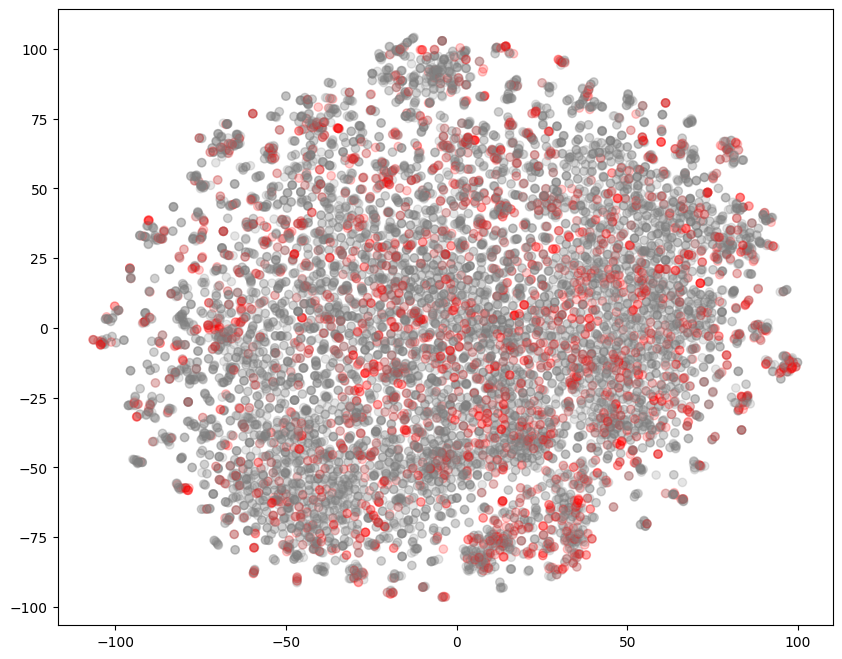

In [121]:
FS = (10, 8)
fig, ax = plt.subplots(figsize=FS)
# Make points translucent so we can visually identify regions with a high density of overlapping points
colors = []
for label, coords in zip(emotion_labels, X_embedded):
    # print(coords)
    # if label == 'neutral':
    # if label == 'anger':
    if label == "joy":
        colors.append("red")
    else:
        colors.append("gray")
    # elif label == 'anger':
    #     colors.append('red')
    # elif label == 'joy':
    #     colors.append('purple')
    # elif label == 'surprise':
    #     colors.append('blue')
    # else:
    #     colors.append('green')

plt.scatter(X_embedded[:, :1], X_embedded[:, 1:], alpha=0.2, c=colors)
# break

Каких-то очевидных кластеров не видно. Зато красиво.

## Finetune model

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch


from semeval.experiments.kosenko.language_bind.LanguageBind.languagebind import (
    LanguageBind,
    to_device,
    transform_dict,
    LanguageBindImageTokenizer,
)

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 

In [2]:
device = "cuda:0"
device = torch.device(device)
clip_type = {
    "video": "LanguageBind_Video_FT",  # also LanguageBind_Video
    # "audio": "LanguageBind_Audio_FT",  # also LanguageBind_Audio
    # "thermal": "LanguageBind_Thermal",
    # "image": "LanguageBind_Image",
    # "depth": "LanguageBind_Depth",
}

languagebind_model = LanguageBind(clip_type=clip_type, cache_dir="/code/cache_dir")
languagebind_model = languagebind_model.to(device)
# model.eval()
pretrained_ckpt = f"LanguageBind/LanguageBind_Image"
tokenizer = LanguageBindImageTokenizer.from_pretrained(
    pretrained_ckpt, cache_dir="/code/cache_dir/tokenizer_cache_dir"
)
modality_transform = {
    c: transform_dict[c](languagebind_model.modality_config[c])
    for c in clip_type.keys()
}

In [3]:
video = [
    "semeval/experiments/kosenko/language_bind/LanguageBind/assets/video/0.mp4",
]
language = [
    "A lion climbing a tree to catch a monkey.",
    "Training a parrot to climb up a ladder.",
    "Cute parrot is sitting on the floor.",
    "Parrot climbs the small stairs.",
    "Two pandas are eating bamboo.",
]

inputs = {
    "video": to_device(modality_transform["video"](video), device),
}
inputs["language"] = to_device(
    tokenizer(
        language,
        max_length=77,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    ),
    device,
)


class VideoClassif(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = languagebind_model
        self.linear = torch.nn.Linear(768, 2, bias=False)

    def forward(self, x):
        result = self.model(x)
        # print(result)
        result = self.linear(result["video"])
        return result


video_classif = VideoClassif()
video_classif.to(device)
output = video_classif(inputs)
loss_func = torch.nn.CrossEntropyLoss()
loss = loss_func(output, torch.tensor([1], device=device))
print(loss)
loss.backward()

tensor(1.1404, device='cuda:0', grad_fn=<NllLossBackward0>)


### freeze model

In [7]:
for param in video_classif.named_parameters():
    print(param[0])
    if not "model" in param[0]:
        print(param[0])
    else:
        param[1].requires_grad_(False)

model.modality_encoder.video.embeddings.class_embedding
model.modality_encoder.video.embeddings.patch_embedding.weight
model.modality_encoder.video.embeddings.position_embedding.weight
model.modality_encoder.video.pre_layrnorm.weight
model.modality_encoder.video.pre_layrnorm.bias
model.modality_encoder.video.encoder.layers.0.temporal_embedding
model.modality_encoder.video.encoder.layers.0.self_attn.k_proj.weight
model.modality_encoder.video.encoder.layers.0.self_attn.k_proj.bias
model.modality_encoder.video.encoder.layers.0.self_attn.v_proj.weight
model.modality_encoder.video.encoder.layers.0.self_attn.v_proj.bias
model.modality_encoder.video.encoder.layers.0.self_attn.q_proj.weight
model.modality_encoder.video.encoder.layers.0.self_attn.q_proj.bias
model.modality_encoder.video.encoder.layers.0.self_attn.out_proj.weight
model.modality_encoder.video.encoder.layers.0.self_attn.out_proj.bias
model.modality_encoder.video.encoder.layers.0.layer_norm1.weight
model.modality_encoder.video.enco

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


count_parameters(video_classif)

1536

In [4]:
from peft import (
    get_peft_config,
    PeftModel,
    PeftConfig,
    get_peft_model,
    LoraConfig,
    TaskType,
)

peft_config = LoraConfig(
    task_type=TaskType.TOKEN_CLS,
    inference_mode=False,
    r=16,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="all",
    target_modules=[
        'k_proj',
        'v_proj',
        'q_proj',
        'out_proj',
    ]
)
model = get_peft_model(video_classif, peft_config)
model.print_trainable_parameters()

trainable params: 7,968,512 || all params: 536,096,512 || trainable%: 1.486395046718752
